### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import shutil
import os

In [2]:
# remove all saved images in the current directory
for file in os.listdir():
    if file.endswith('.png'):
        os.remove(file)
# remove all saved images in the directory TestCase1
for file in os.listdir('./TestCase1/'):
    if file.endswith('.png'):
        os.remove('./TestCase1/' + file)

### Exact Solution

Define exact solution $f(x, y)$

In [3]:
BL = 0.1
N = 65
def exactSol(x, y):
    return x*y*y - y*y*np.exp((2*(x - 1))/BL) - x*np.exp(3*(y - 1)/BL) + np.exp((2*(x - 1) + 3*(y - 1))/BL)

Plot the exact solution

In [ ]:
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)
Z = exactSol(X, Y)

plt.figure(figsize=(12, 6))
plt.imshow(Z, cmap='jet', origin='lower')
plt.colorbar()
plt.show()
print(Z.shape)

Contour plot of the exact solution

In [ ]:
k = 1.3
plt.figure(figsize=(8*k, 6*k))
cp = plt.contourf(X, Y, Z, cmap='jet', vmin=0)
plt.colorbar(cp)  # Add a colorbar
plt.savefig('exacsfield.png') 
plt.show()

### Plot Functions

In [5]:
def plots2D(Z, title = None, vmin=None, vmax=None):
    N = Z.shape[0]
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y)
    
    plt.figure(figsize=(12, 6))
    im = plt.imshow(Z, cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im)
    plt.tight_layout()
    if title is not None:
        plt.title(title)
        plt.savefig( './TestCase1/' + title + '.png')  # Save as PNG
    plt.show()

In [6]:
def plots2Dcontour(Z, title = None, vmin=None, vmax=None, colormap='jet'):
    N = Z.shape[0]
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y)
    
    plt.figure(figsize=(8*1.2, 6*1.2))
    cp = plt.contourf(X, Y, Z, cmap=colormap, vmin=vmin, vmax=vmax)
    plt.colorbar(cp)  # Add a colorbar
    plt.tight_layout()
    if title is not None:
        plt.title(title)
        plt.savefig( './TestCase1/' + title + '.png')  # Save as PNG
    plt.show()

### Import & plot $\texttt{model.f()}$ from $\texttt{femR}$ 

In [ ]:
# copy file fdaPDE_SUPG_sol.txt from the build directory to the current directory with shutil
try:
    os.makedirs('TestCase1')
except:
    pass
fdaPDE_SUPG_sol  = '../../../fdaPDE-core/test/build/fdaPDE_SUPG_sol.txt'
shutil.copy(fdaPDE_SUPG_sol, './TestCase1/fdaPDE_SUPG_sol.txt')

In [ ]:
path = 'TestCase1/fdaPDE_SUPG_sol.txt'
# path = 'TestCase1/fdaPDE_SUPG_sol_no_stab.txt'
# path = 'TestCase1/fdaPDE_SUPG_sol_pert.txt'
data = np.loadtxt(path, delimiter=',')
print(data.size)
N = int(np.sqrt(data.size))
print("N = ", N)
data = data.reshape(N,N)
plots2D(data, 'TestCase1_femR_sol')
plots2Dcontour(data, 'TestCase1_femR_sol_contour')
print(data.shape)

Check discrepancies between femR and exact

In [ ]:
femR_error = np.abs(data - Z)
norm_error_2 = np.linalg.norm(femR_error, 2)
norm_error_inf = np.linalg.norm(femR_error, np.inf)
print("norm2 = ", norm_error_2)
print("norm_inf = ", norm_error_inf)
plots2D(femR_error, 'TestCase1_error_femR_exact')
plots2Dcontour(femR_error, 'TestCase1_error_femR_exact_contour', colormap='jet')

### Delete ALL previous files in directory `TransportTestCase1`

In [ ]:
# delete a directory and all its content
shutil.rmtree('../data/transport/TransportTestCase1')
# recreate the directory empty
os.makedirs('../data/transport/TransportTestCase1')

### Generate locations and observations for FreeFEM

In [ ]:
nStart = 5
nEnd = 25
nStep = 5
for n in range(nStart, nEnd + 1, nStep):
    t = np.linspace(0, 1, n)
    x, y = np.meshgrid(t, t)
    locs = np.array([x.flatten(), y.flatten()]).T     # careful with the ordering
    # locs = np.array([y.flatten(), x.flatten()]).T       # careful with the ordering
    np.savetxt('../data/transport/TransportTestCase1/locs' + str(n) + '.txt', locs.flatten(), delimiter=',', fmt='%.6f')
    observations = exactSol(locs[:,0], locs[:,1])
    np.savetxt('../data/transport/TransportTestCase1/observations' + str(n) + '.txt', observations, delimiter=',', fmt='%.16f')

# check the last observation (might be flipped)
plots2D(observations.reshape(nEnd, nEnd))

### Save $\texttt{expected()}$ for FreeFEM format from exact solution

In [ ]:
# careful with the mesh size, exact solution is plotted on a mesh of size 65x65
expected = np.copy(Z.flatten())
np.savetxt('../data/transport/testPsi/expected.txt', expected, delimiter=',', fmt='%.16f')
plots2D(expected.reshape(65,65))

### Generate locations and observations for $\texttt{fdaPDE-cpp}$

In [ ]:
nStart = 5
nEnd = 25
nStep = 5
for n in range(nStart, nEnd + 1, nStep):
    t = np.linspace(0, 1, n)
    x, y = np.meshgrid(t, t)
    locs = np.array([x.flatten(), y.flatten()]).T # row major ordering
    
    observations = exactSol(locs[:,0], locs[:,1])
    row_indices = np.arange(1, n*n + 1)
    result_matrix = np.column_stack((row_indices, observations))
    column_names = np.array(['', 'x'])
    result_matrix = np.vstack((column_names, result_matrix))
    np.savetxt('../data/transport/TransportTestCase1/observations' + str(n) + '.csv', result_matrix, delimiter=',', fmt='%s')
    
    locs = np.column_stack((row_indices, locs))
    column_names = np.array(['', 'V1', 'V2'])
    locs = np.vstack((column_names, locs))
    np.savetxt('../data/transport/TransportTestCase1/locs' + str(n) + '.csv', locs, delimiter=',', fmt='%s')

### Save $\texttt{expected()}$ for $\texttt{fdaPDE-cpp}$ format from exact solution

In [ ]:
expected = np.copy(Z)
N = expected.size
row_indices = np.arange(1, N + 1)
expected = np.column_stack((row_indices, expected.flatten())) # row major ordering
column_names = np.array(['', 'x'])
expected = np.vstack((column_names, expected ))
np.savetxt('../data/transport/TransportTestCase1/expected.csv', expected, delimiter=',', fmt='%s')

___________________________ run testcase from FreeFEM or fdaPDE-cpp ___________________________

### Plot $\texttt{model.f()}$ from $\texttt{fdaPDE-cpp}$

Copy model.f() files from fdaPDE-cpp build directory to the current directory

In [ ]:
try:
    shutil.rmtree('./TestCase1/modelf/')
except:
    pass
os.makedirs('TestCase1/modelf/')

for file in os.listdir('../build/'):
    if file.startswith('modelf'):
        shutil.copy('../build/' + file, './TestCase1/modelf/' + file)
        

Plot the average model.f() from fdaPDE-cpp

In [ ]:
path  = './TestCase1/modelf/'
average_modelf = 0
for n in range(nStart, nEnd + 1, nStep):
    modelf = np.loadtxt(path + 'modelf' + str(n) + '.txt', delimiter=',')
    N = int(np.sqrt(modelf.size))
    modelf = modelf.reshape(N,N)
    average_modelf += modelf
    # plots2D(modelf, 'TestCase1_modelf' + str(n))
average_modelf /= (nEnd - nStart) / nStep
print('average model.f()')
# plots2D(average_modelf, 'TestCase1_modelf_average_fdaPDE-cpp')
plots2Dcontour(average_modelf, 'TestCase1_modelf_average_fdaPDE-cpp_contour')

Plot all model.f() from fdaPDE-cpp in a subplot

In [ ]:
plt.figure(figsize=(25, 5))
for i in range(nStart, nEnd + 1, nStep):
    plt.subplot(1, 5, i//5)
    modelf = np.loadtxt(path + 'modelf' + str(i) + '.txt', delimiter=',')
    N = int(np.sqrt(modelf.size))
    modelf = modelf.reshape(N,N)
    
    # plot with imageshow
    # plt.imshow(modelf, cmap='jet', origin='lower')
    
    # plot with contourf
    t = np.linspace(0, 1, N)
    X, Y = np.meshgrid(t, t)
    cp = plt.contourf(X, Y, modelf, cmap='jet', vmin=0)
    
    plt.title('model.f(), ' + str(i) + ' obs')
    plt.colorbar()    
# save the plot
plt.tight_layout()
plt.savefig('model_f_subplot_fdaPDE-cpp.png')
plt.show()

Plot the error of the average model.f() from fdaPDE-cpp

In [ ]:
nStart = 5
nEnd = 25
nStep = 5
plt.figure(figsize=(25, 5))

for i in range(nStart, nEnd + 1, nStep):
    plt.subplot(1, 5, i//5)
    modelf = np.loadtxt(path + 'modelf' + str(i) + '.txt', delimiter=',')
    N = int(np.sqrt(modelf.size))
    modelf = modelf.reshape(N,N)
    error = np.abs(modelf - Z)
    norm_error_2 = np.linalg.norm(error, 2)
    norm_error_inf = np.linalg.norm(error, np.inf)
    print("norm2 = ", norm_error_2)
    print("norm_inf = ", norm_error_inf)
    
    #plot with imageshow
    # plt.imshow(error, cmap='jet', origin='lower')
    
    # plot with contourf
    t = np.linspace(0, 1, N)
    X, Y = np.meshgrid(t, t)
    cp = plt.contourf(X, Y, error, cmap='jet', vmin=0)
    
    plt.title('model.f(), ' + str(i) + ' obs')
    plt.colorbar()
plt.tight_layout()
plt.savefig('model_f_error_subplot_fdaPDE-cpp.png')
plt.show()

### Import & plot $\texttt{model.f()}$ from FreeFEM

Plot a single model.f() from FreeFEM

In [ ]:
path = '../data/transport/testPsi/'
x = np.linspace(0, 1, 65)
y = np.linspace(0, 1, 65)
X, Y = np.meshgrid(x, y)

nObs = 625

modelf = np.loadtxt(path + 'modelf_' + str(nObs) + '.txt', delimiter=',')
N = int(np.sqrt(modelf.size))
modelf = modelf.reshape(N,N)

# plot with imageshow
plt.imshow(modelf, cmap='jet', origin='lower')

# plot with contourf
# cp = plt.contourf(X, Y, modelf, cmap='jet', vmin=0)

plt.title('model.f() obs')
plt.colorbar()

plt.tight_layout()
plt.savefig('model_f_femR_' + str(nObs) + '.png')
plt.show()

In [ ]:
# plot in a subplot 2x2 the exact solution and the perturbed observations
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
# plt.imshow(Z, cmap='jet', origin='lower')
# plt.colorbar()
t = np.linspace(0, 1, 65)
X, Y = np.meshgrid(t, t)
cp = plt.contourf(X, Y, Z, cmap='jet', vmin=0)
plt.title('PDE solution')
plt.subplot(1, 2, 2)
# plt.imshow(data.T, cmap='jet', origin='lower')
plt.colorbar()
cp = plt.contourf(X, Y, data, cmap='jet', vmin=0)
plt.colorbar()
plt.title('reference field (perturbed)')
plt.tight_layout()
plt.savefig('exact_sol_perturbed_obs.png')
plt.show()

Plot all model.f() from FreeFEM in a subplot with the same colorbar range

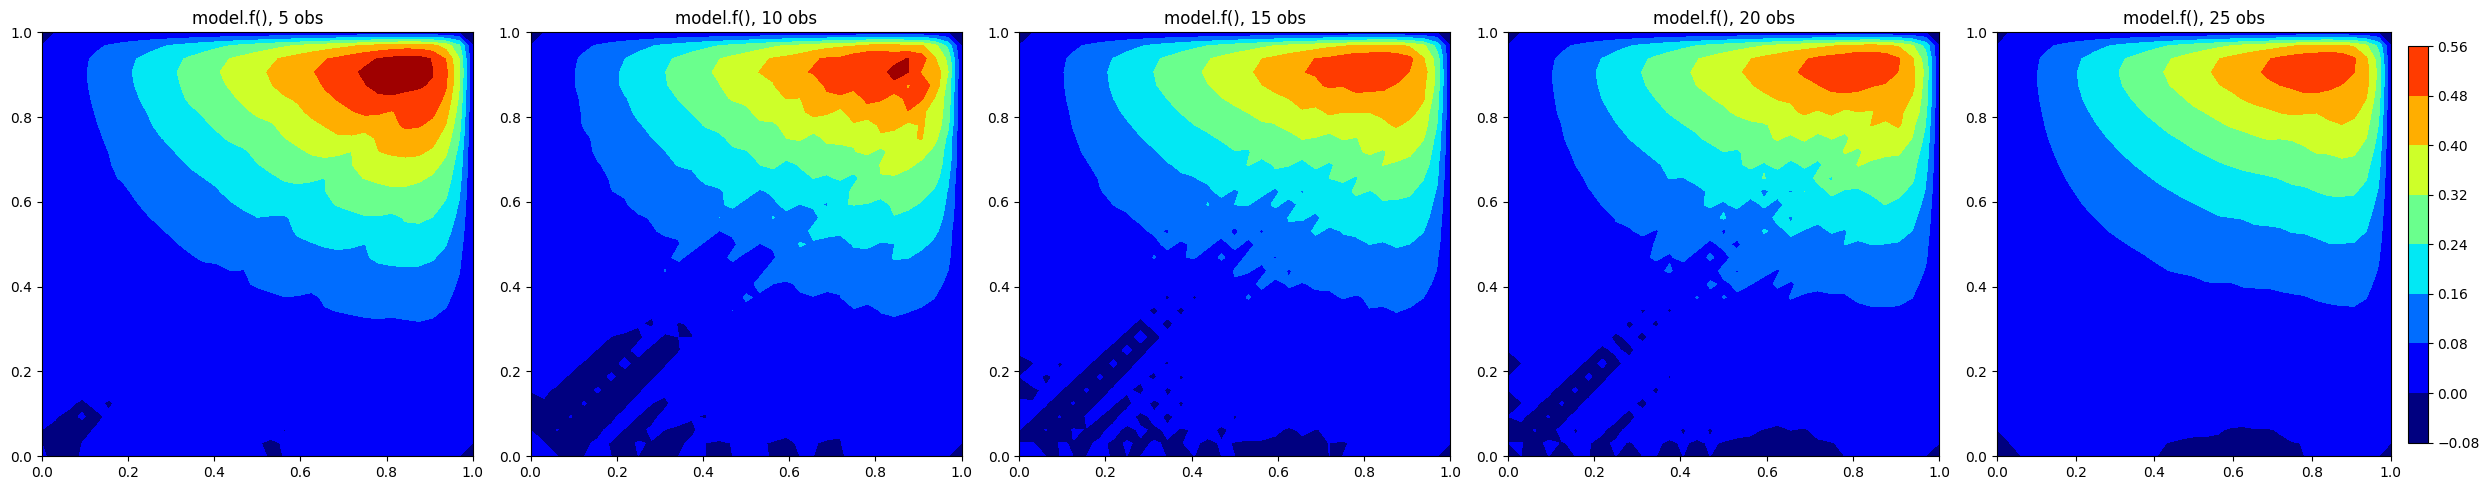

In [71]:
path = '../data/transport/TransportTestCase1/'
plt.figure(figsize=(25, 5))

# Define X and Y
x = np.linspace(0, 1, 33)
y = np.linspace(0, 1, 33)
X, Y = np.meshgrid(x, y)

# Load all data to determine the global min and max
data_list = []
for i in range(5):
    modelf = np.loadtxt(path + 'modelf_' + str(5*(i+1)) + '.txt', delimiter=',')
    N = int(np.sqrt(modelf.size))
    modelf = modelf.reshape(N, N)
    data_list.append(modelf)

# Calculate global min and max
global_min = min(data.min() for data in data_list)
global_max = max(data.max() for data in data_list)

# Plot each subplot with the same colorbar range
for i in range(5):
    plt.subplot(1, 5, i+1)
    cp = plt.contourf(X, Y, data_list[i], cmap='jet', vmin=global_min, vmax=global_max)
    plt.title('model.f(), ' + str(5*(i+1)) + ' obs')
    if i == 4:  # Only add a colorbar to the last subplot
        cbar = plt.colorbar(cp, ax=plt.gca(), fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig('model_f_subplot_freeFEM.png')
plt.show()

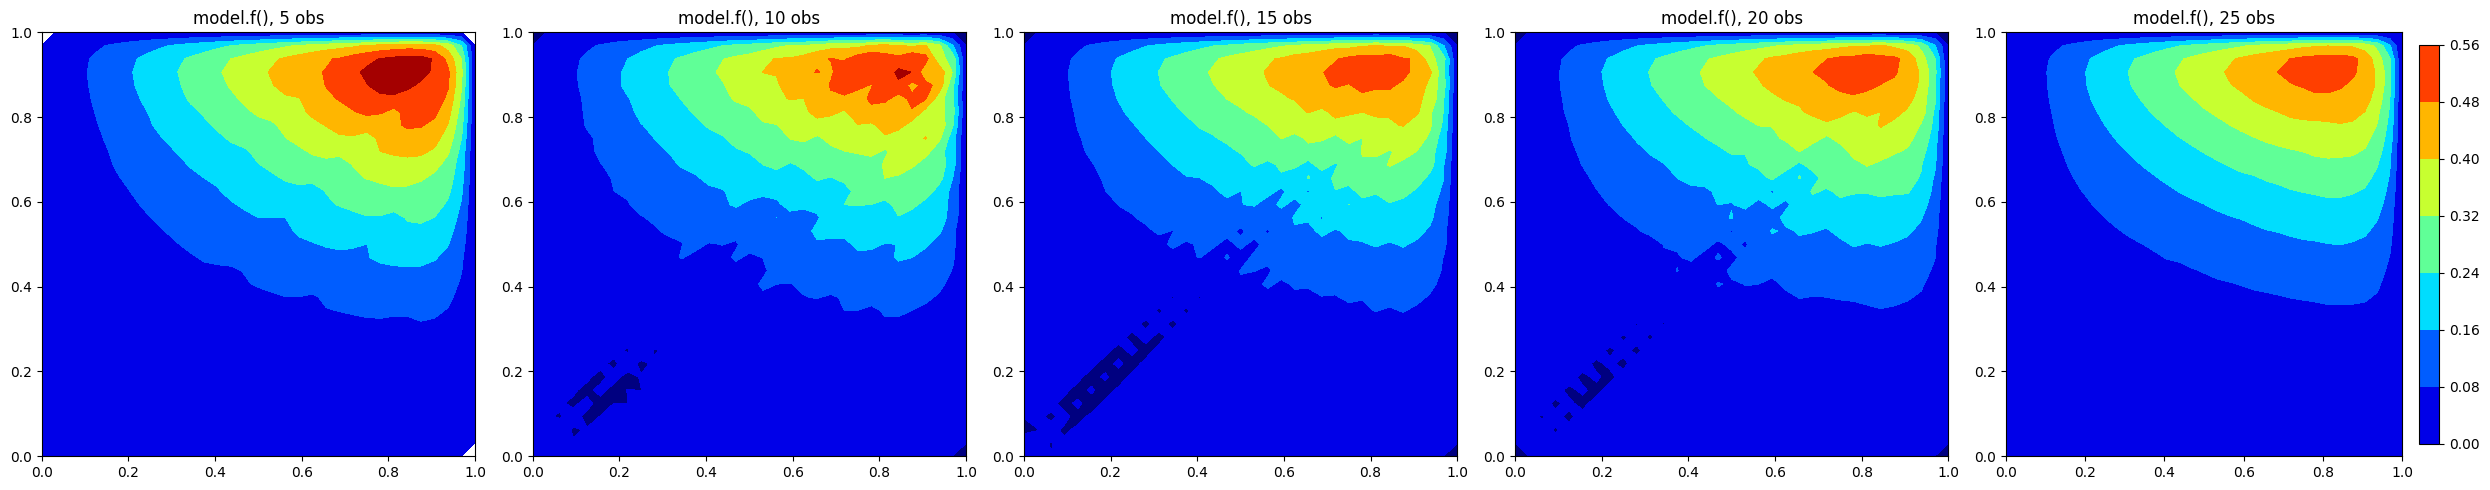

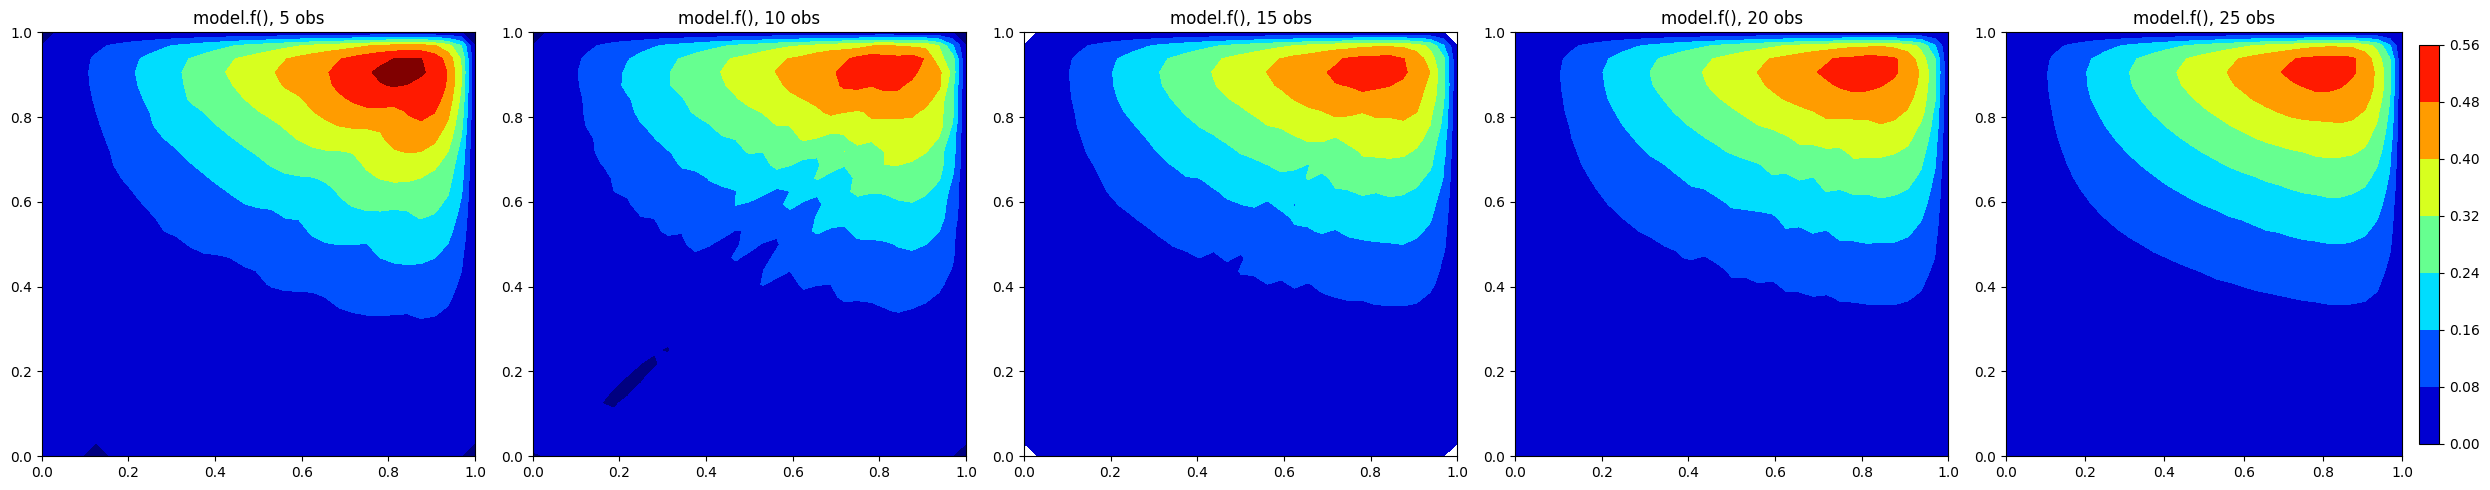

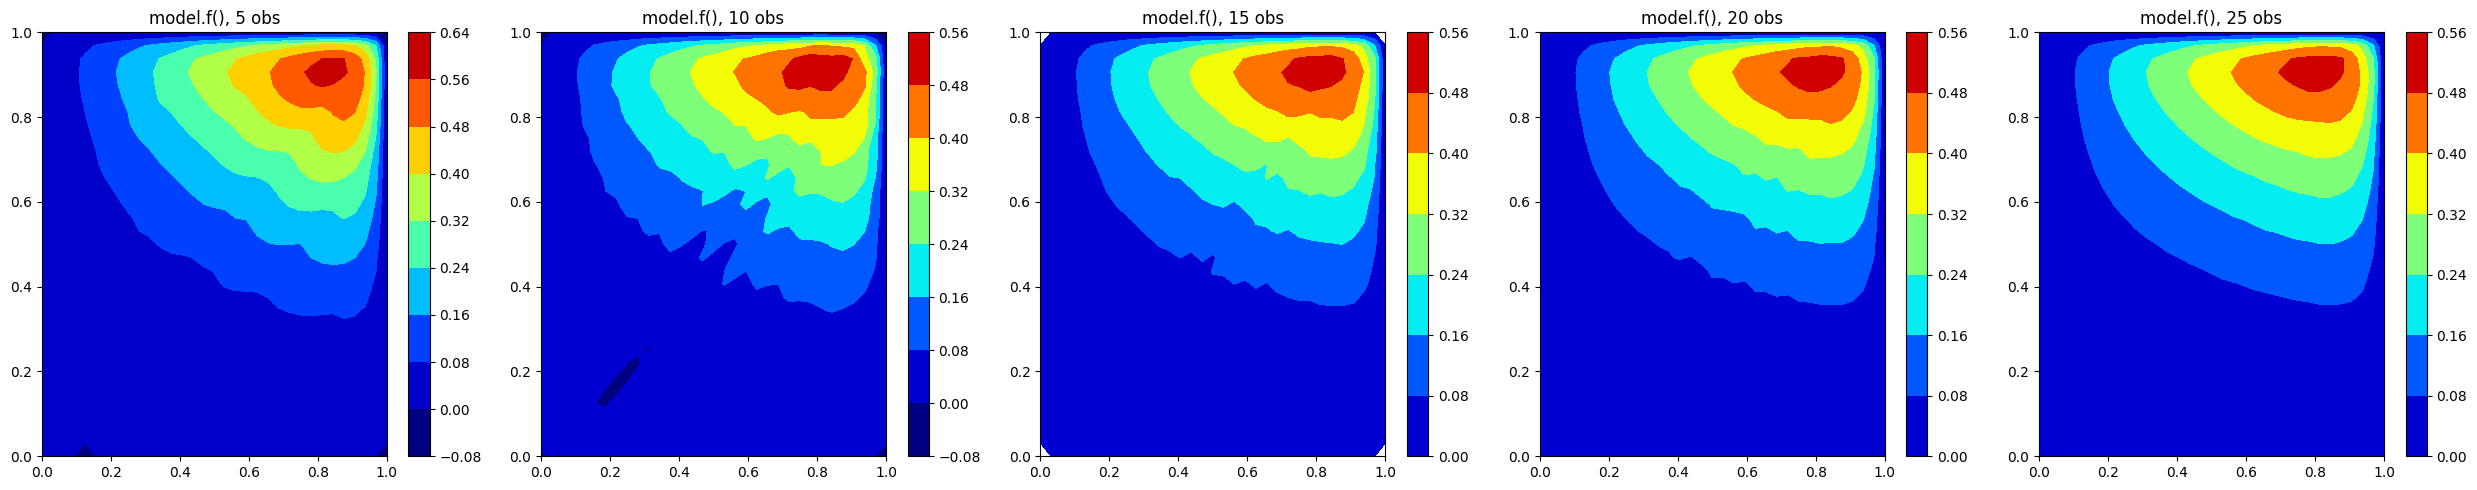

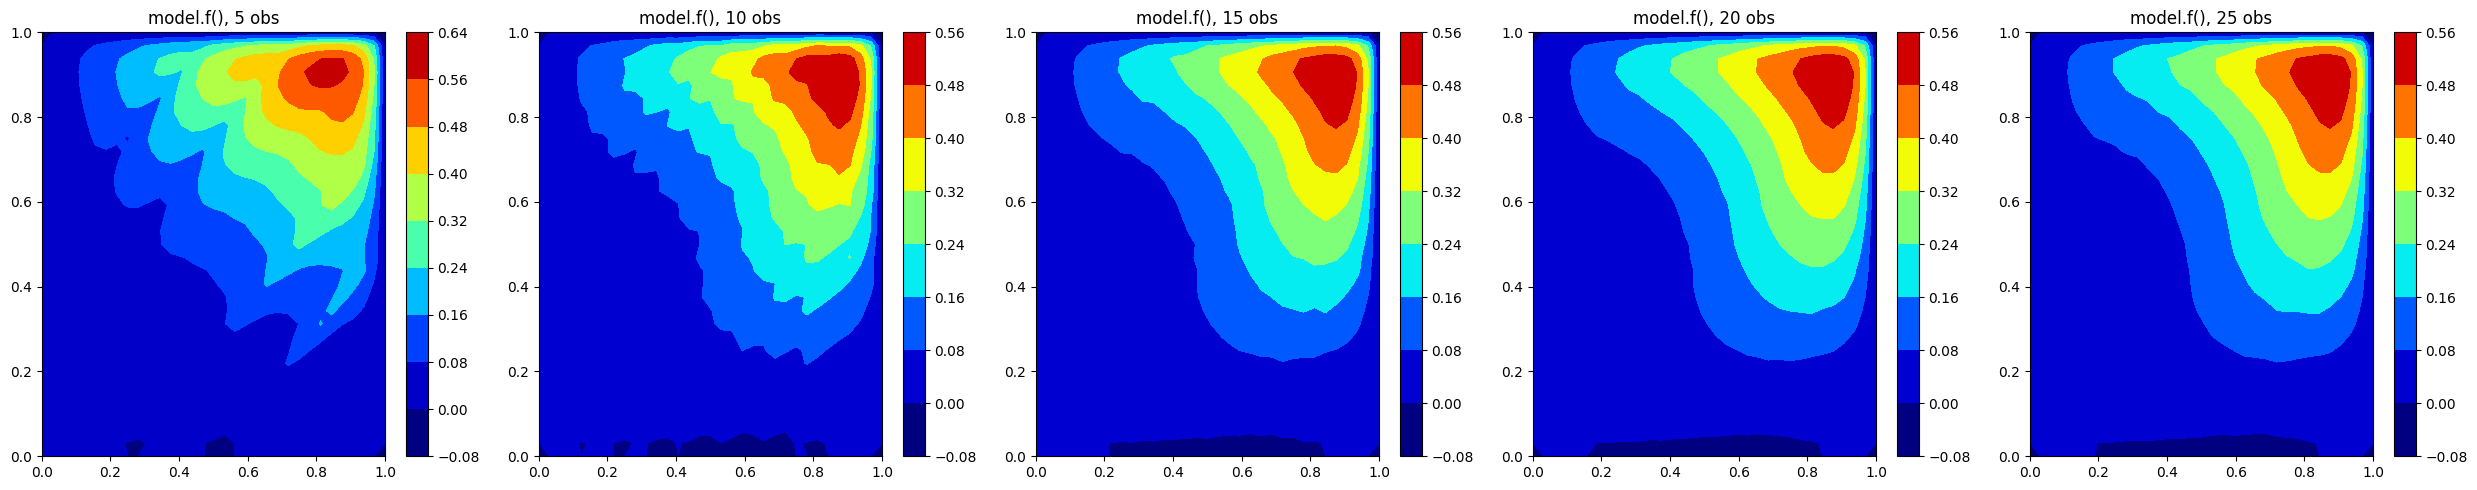

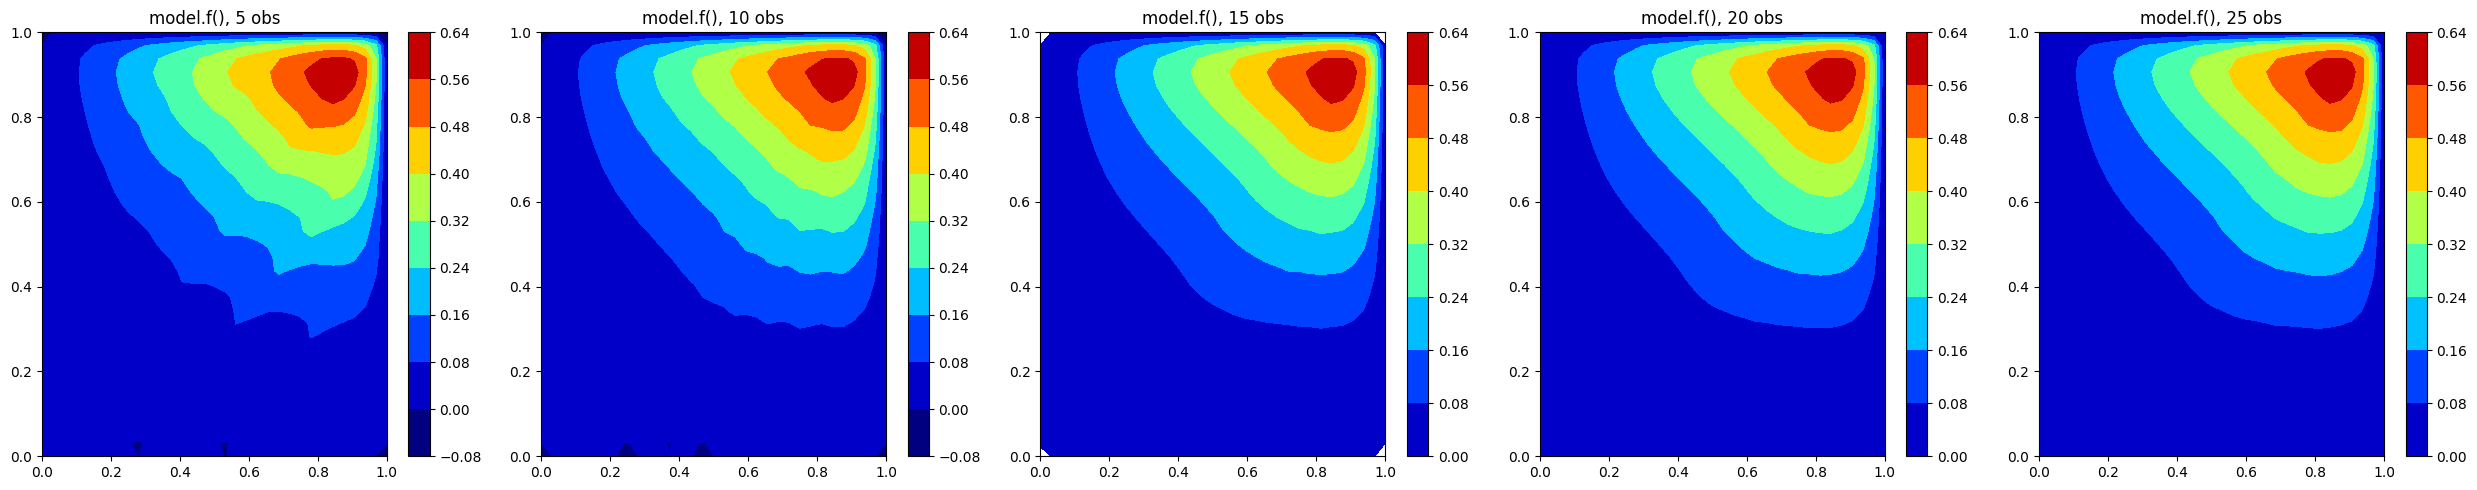

In [49]:
# lambda = 0.15

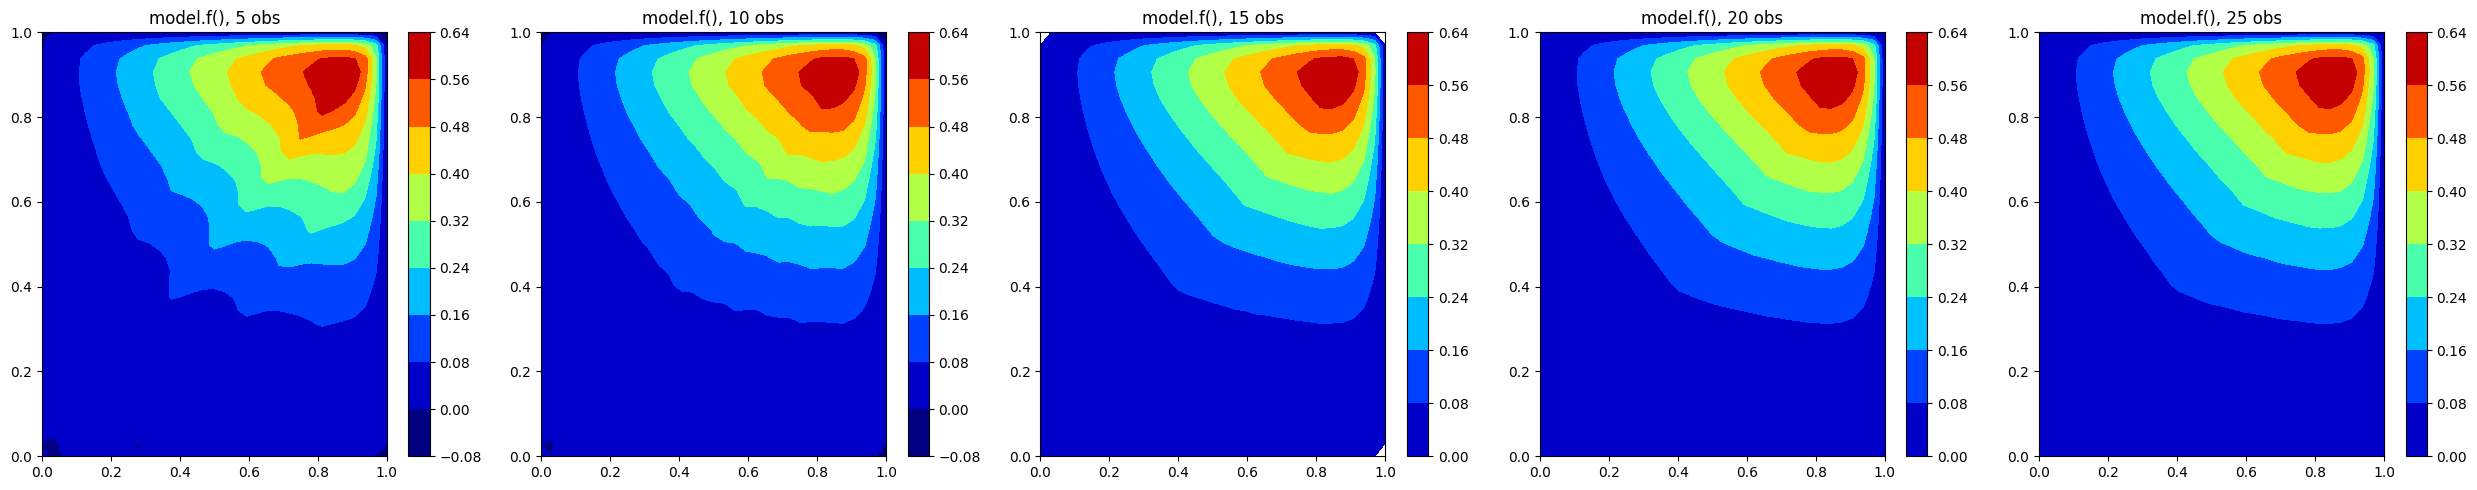

In [48]:
# lambda = 1

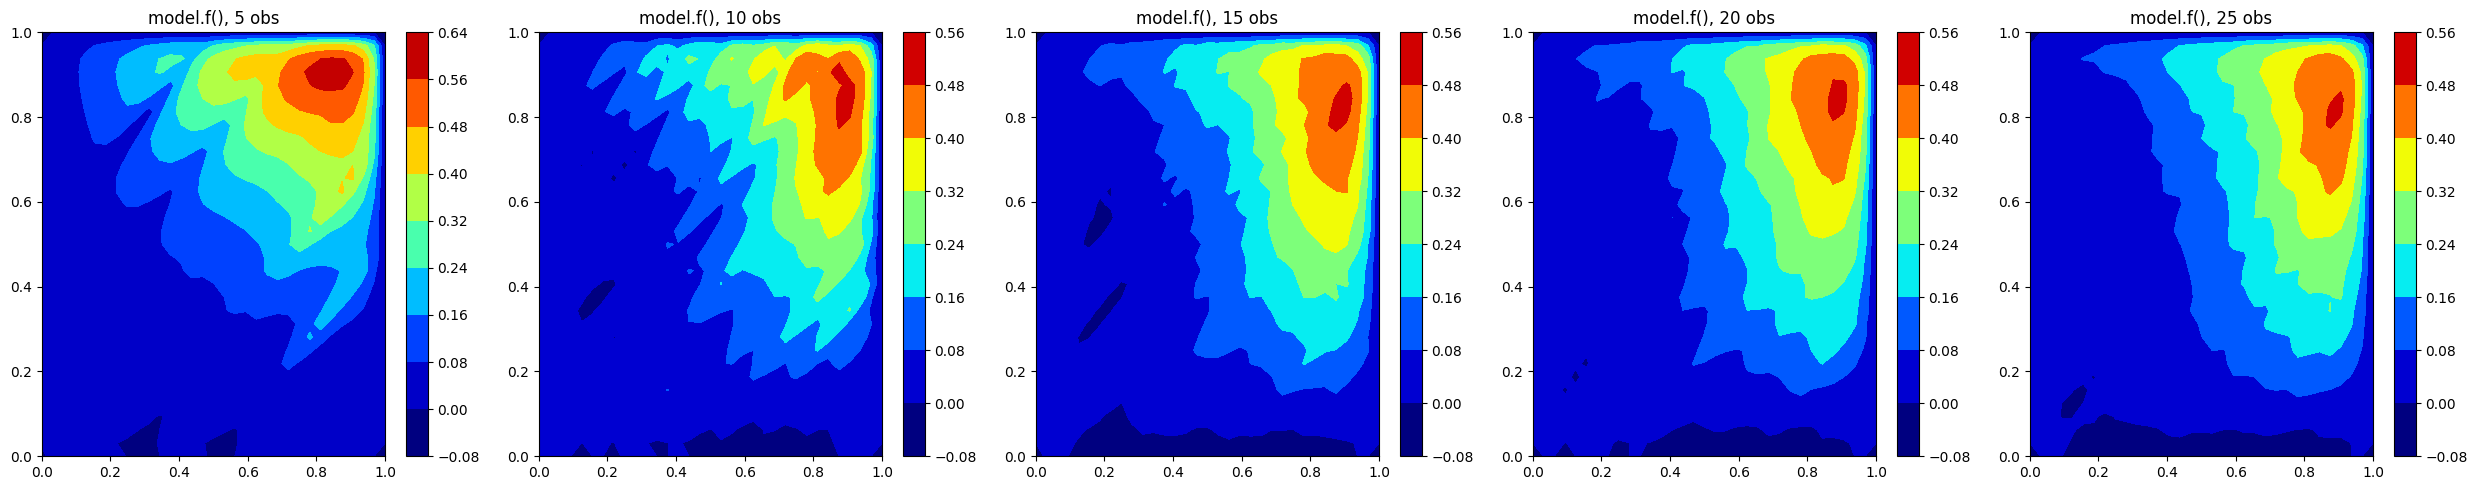

In [43]:
# noisy observations

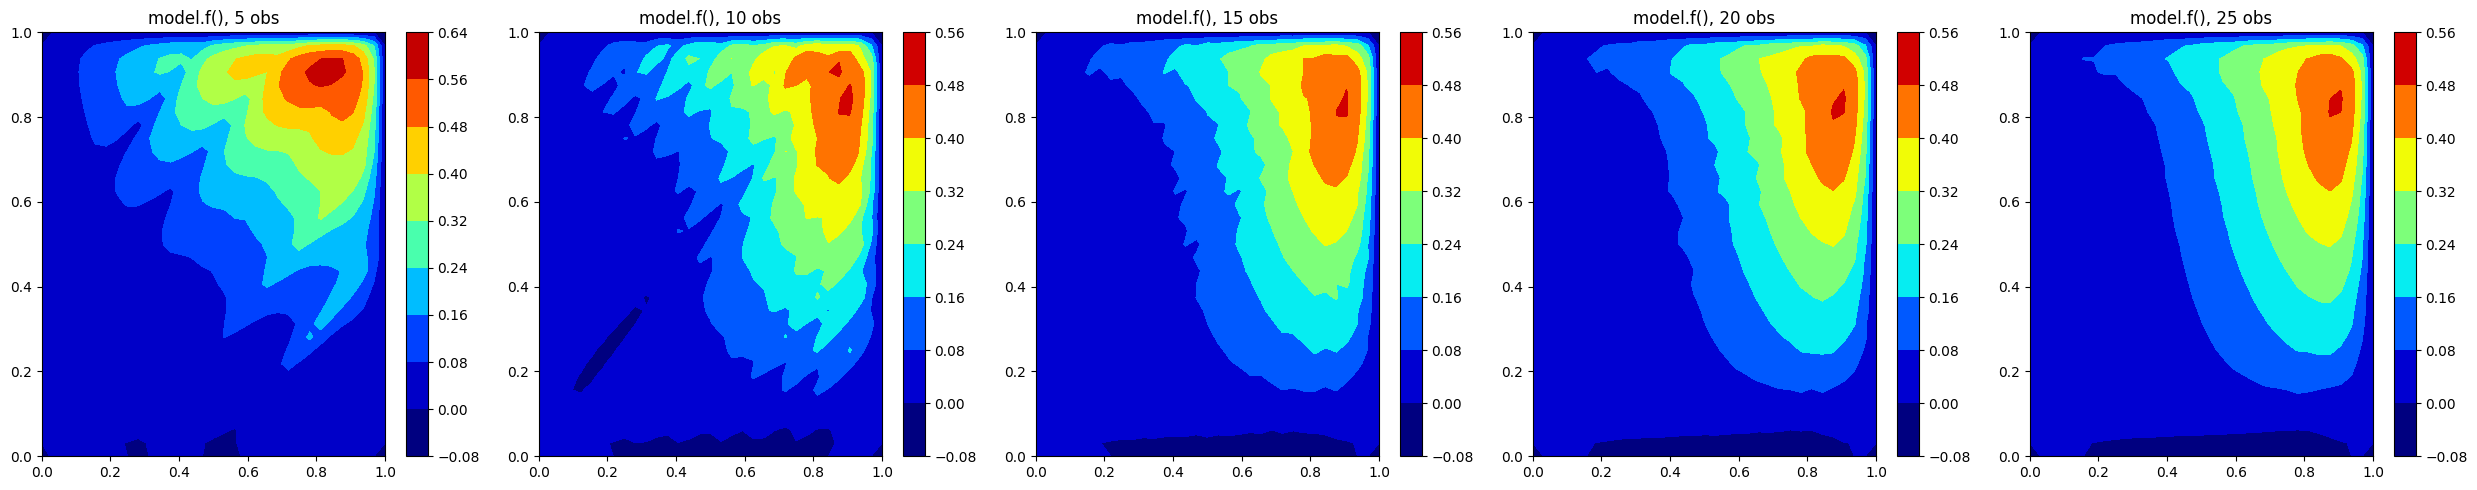

In [39]:
# model with Xi, stabilization parameter = 23.294, lambda = 1e-3, nu=1e-3

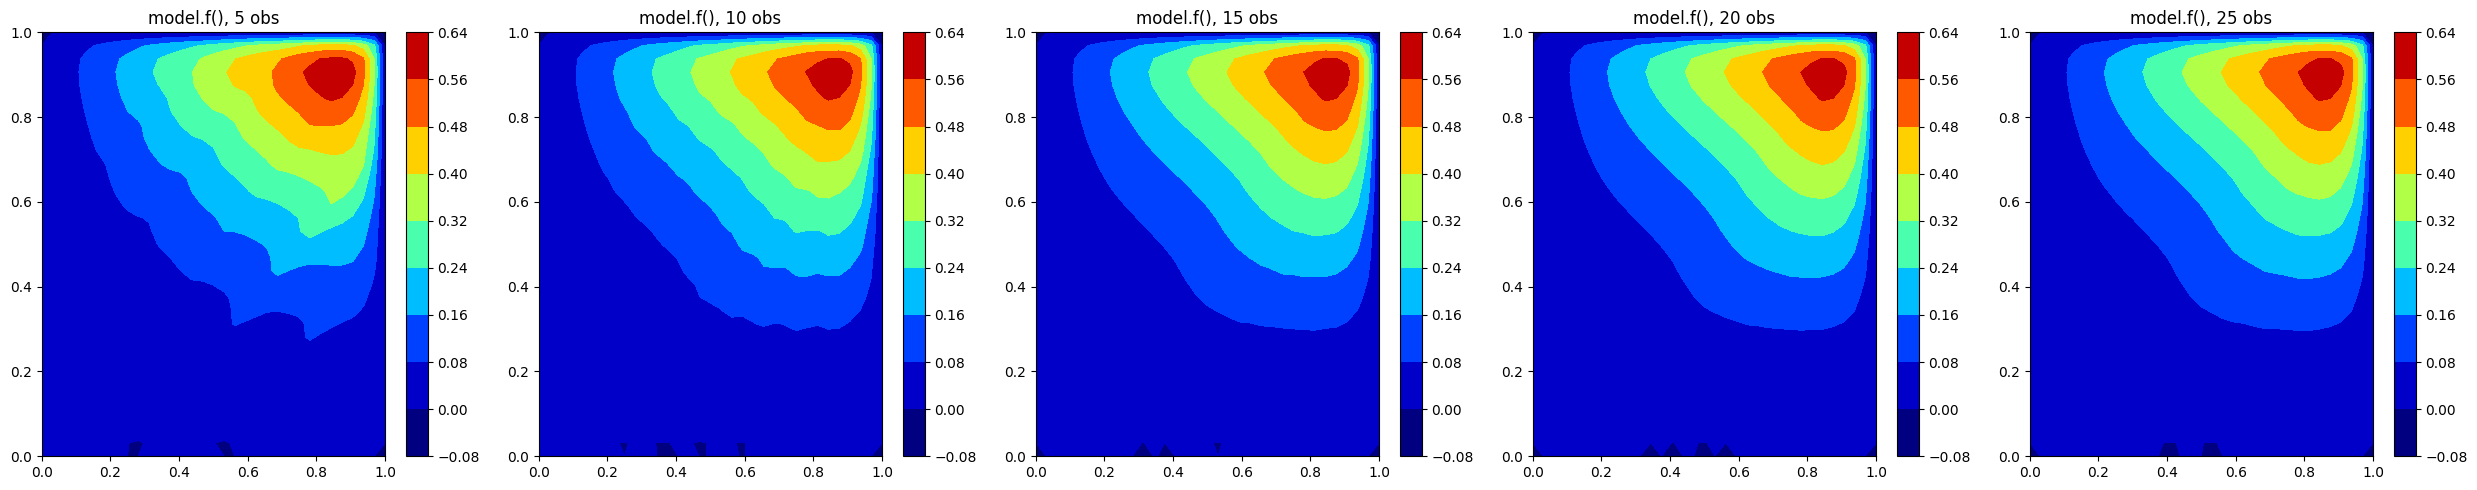

In [38]:
# model with Xi, stabilization parameter = 23.294, lambda = 0.1, nu=1e-3

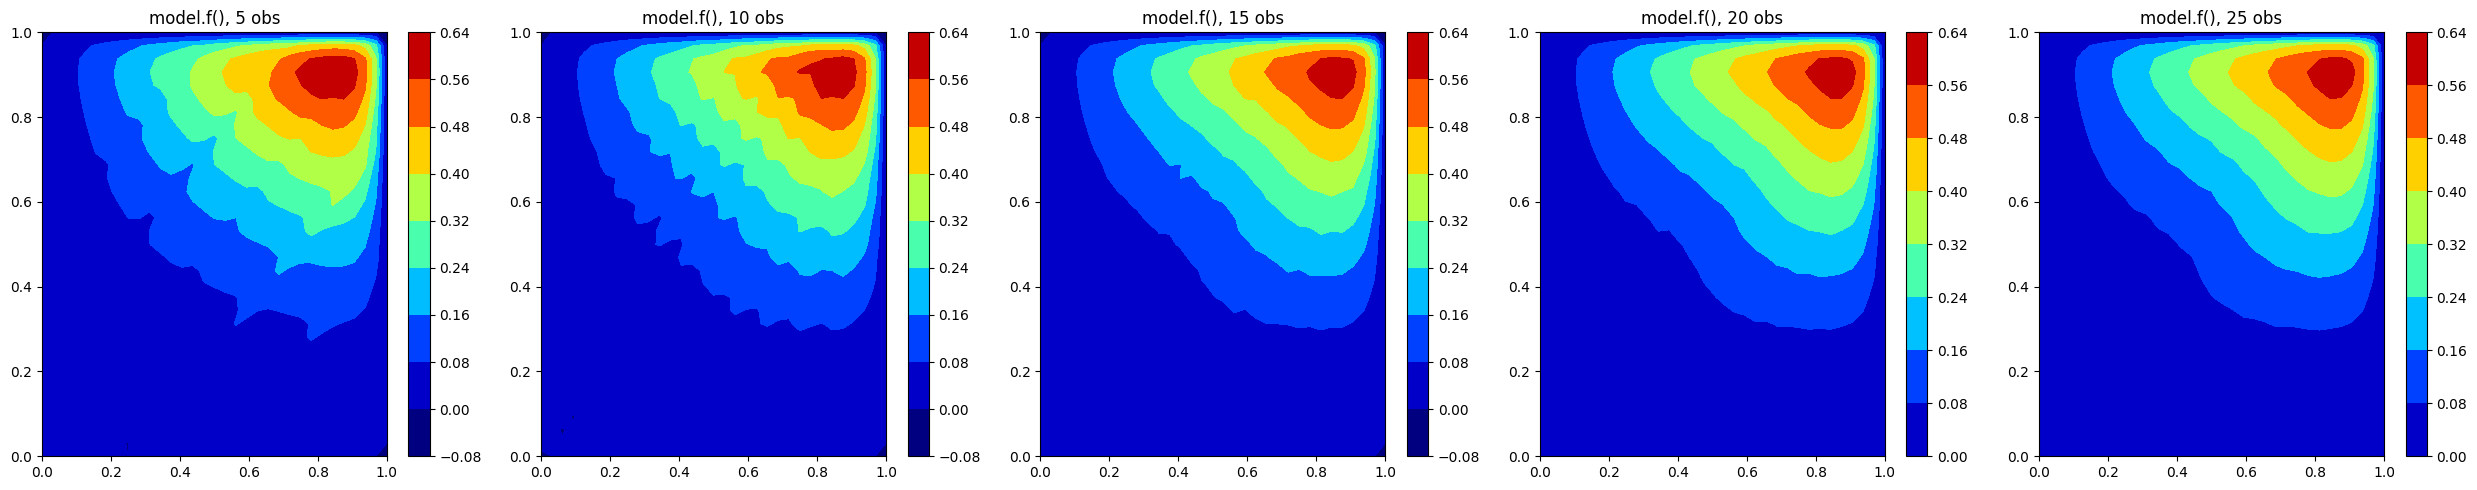

In [36]:
# model withOUT Xi, flipped data, lambda = 0.1

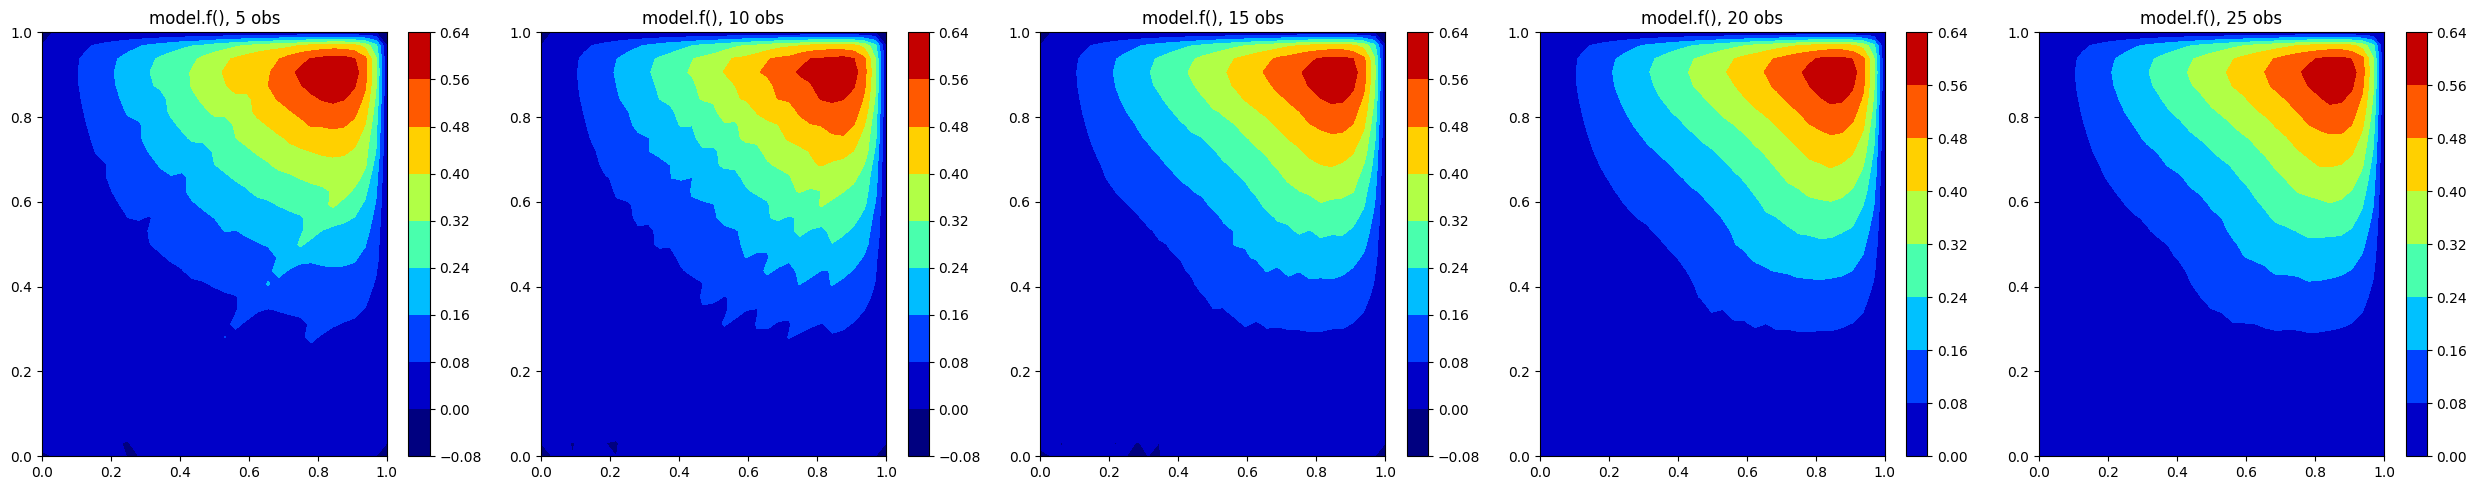

In [35]:
# model with Xi, flipped data, lambda = 0.1

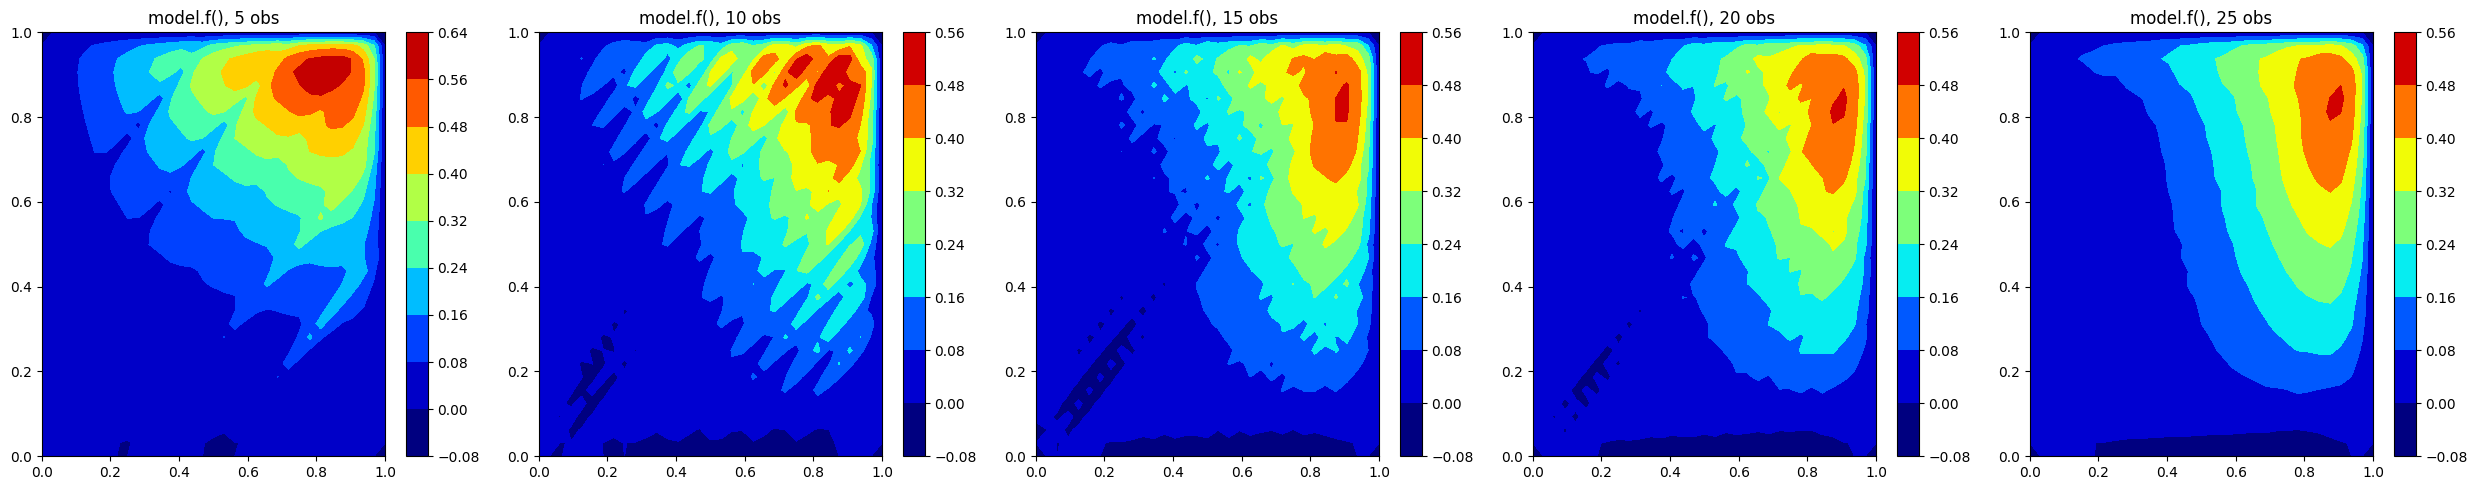

In [33]:
# without Xi, stab param = 23.294, lambda = 1e-3

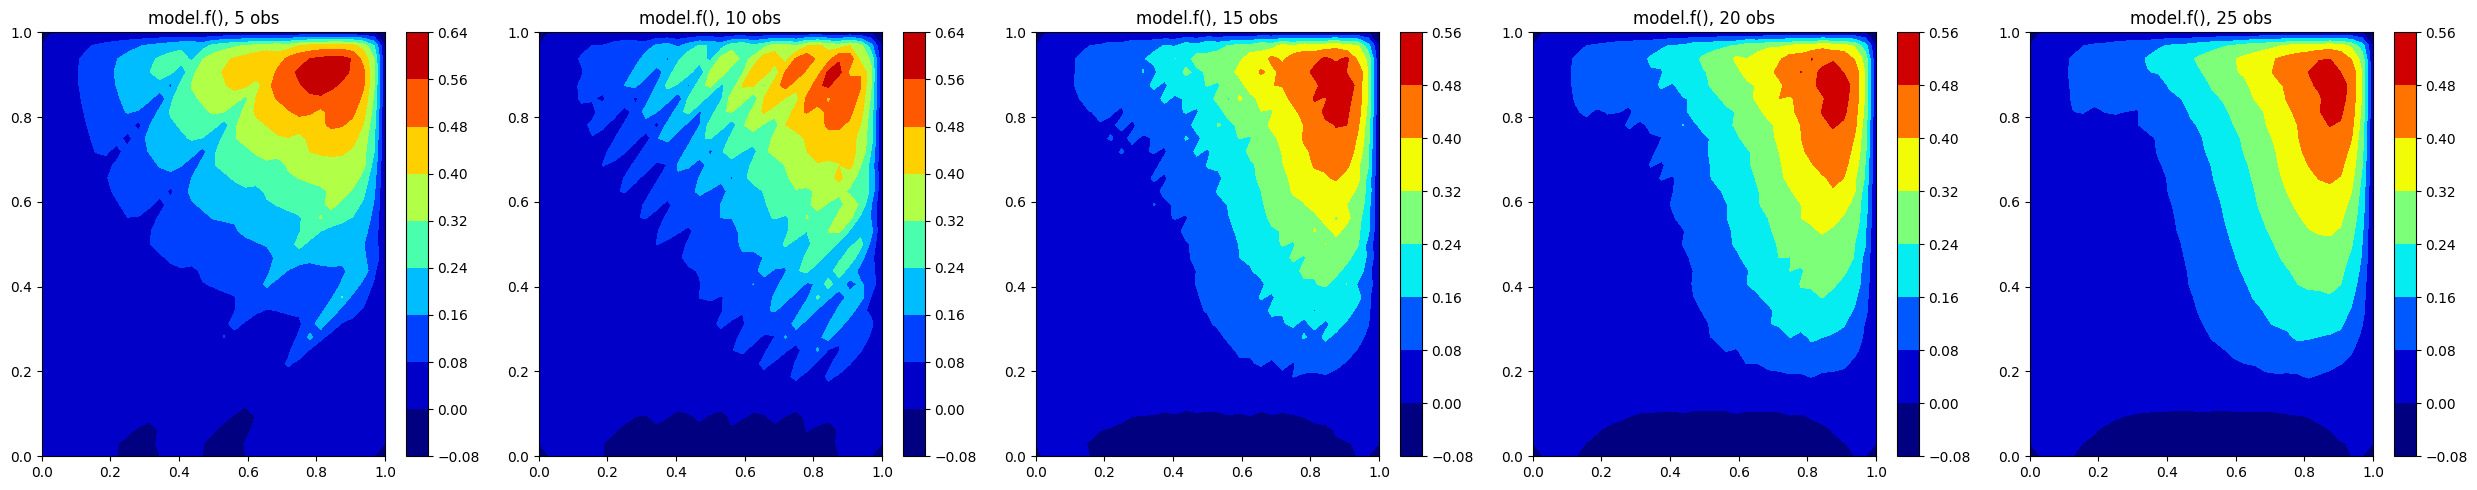

In [31]:
# stab param 46.4, with Xi, lambda = 1e-3

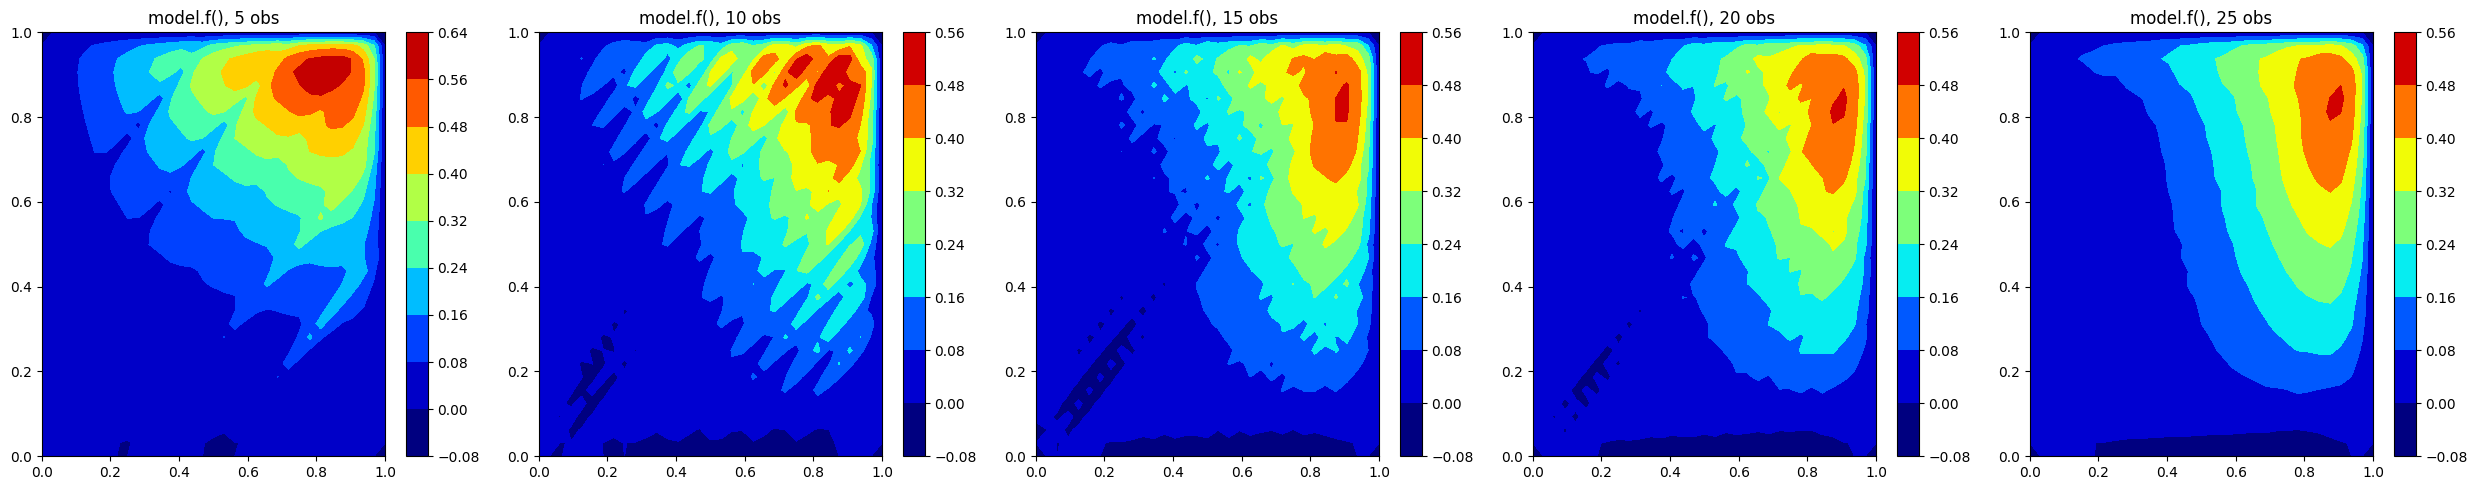

In [18]:
# flipped data, stab_param = 23.294, with Xi, lambda = 1e-3

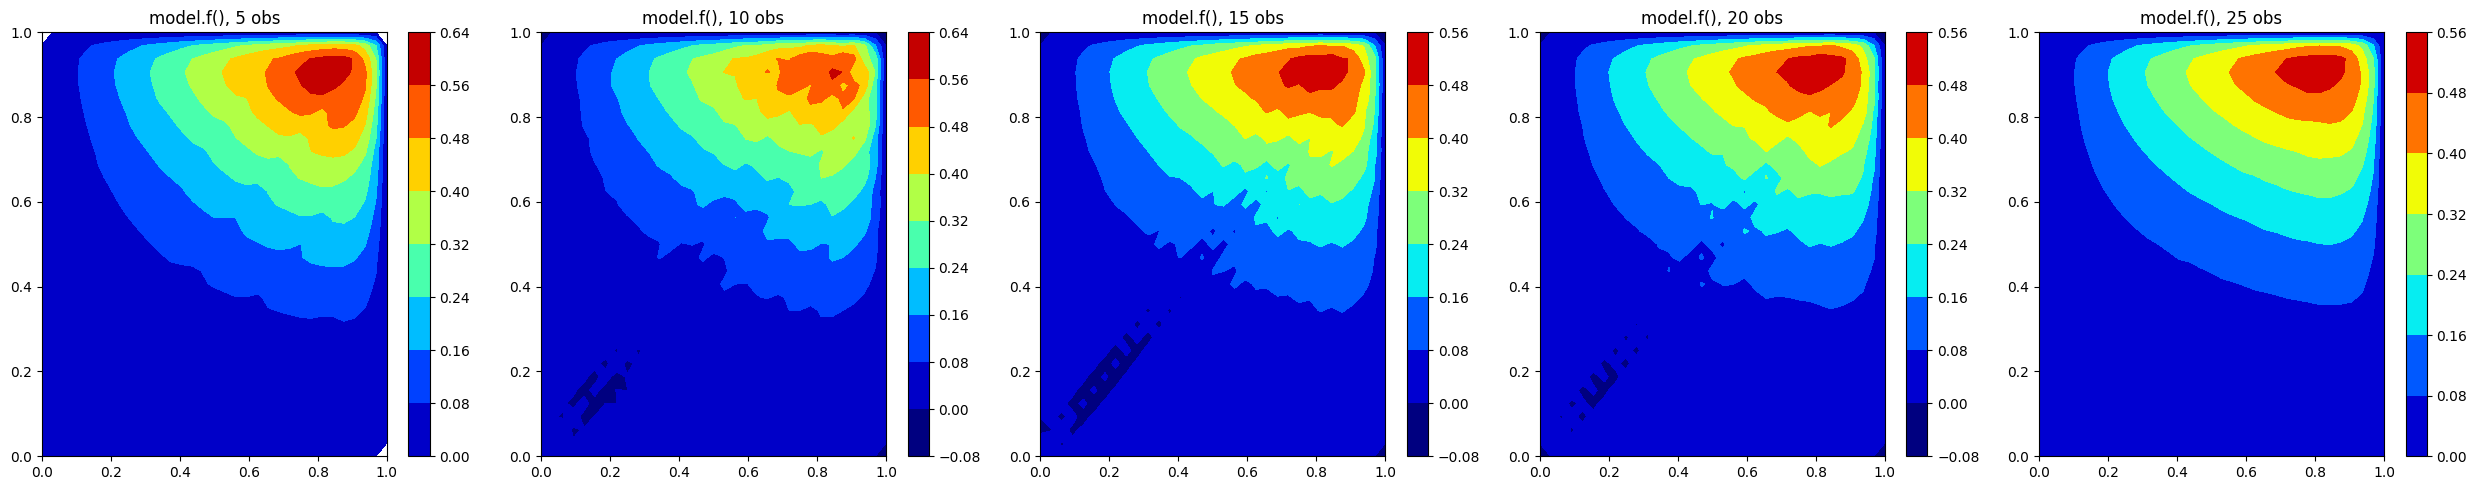

In [27]:
# same thing with Xi, stab_param = 23.294

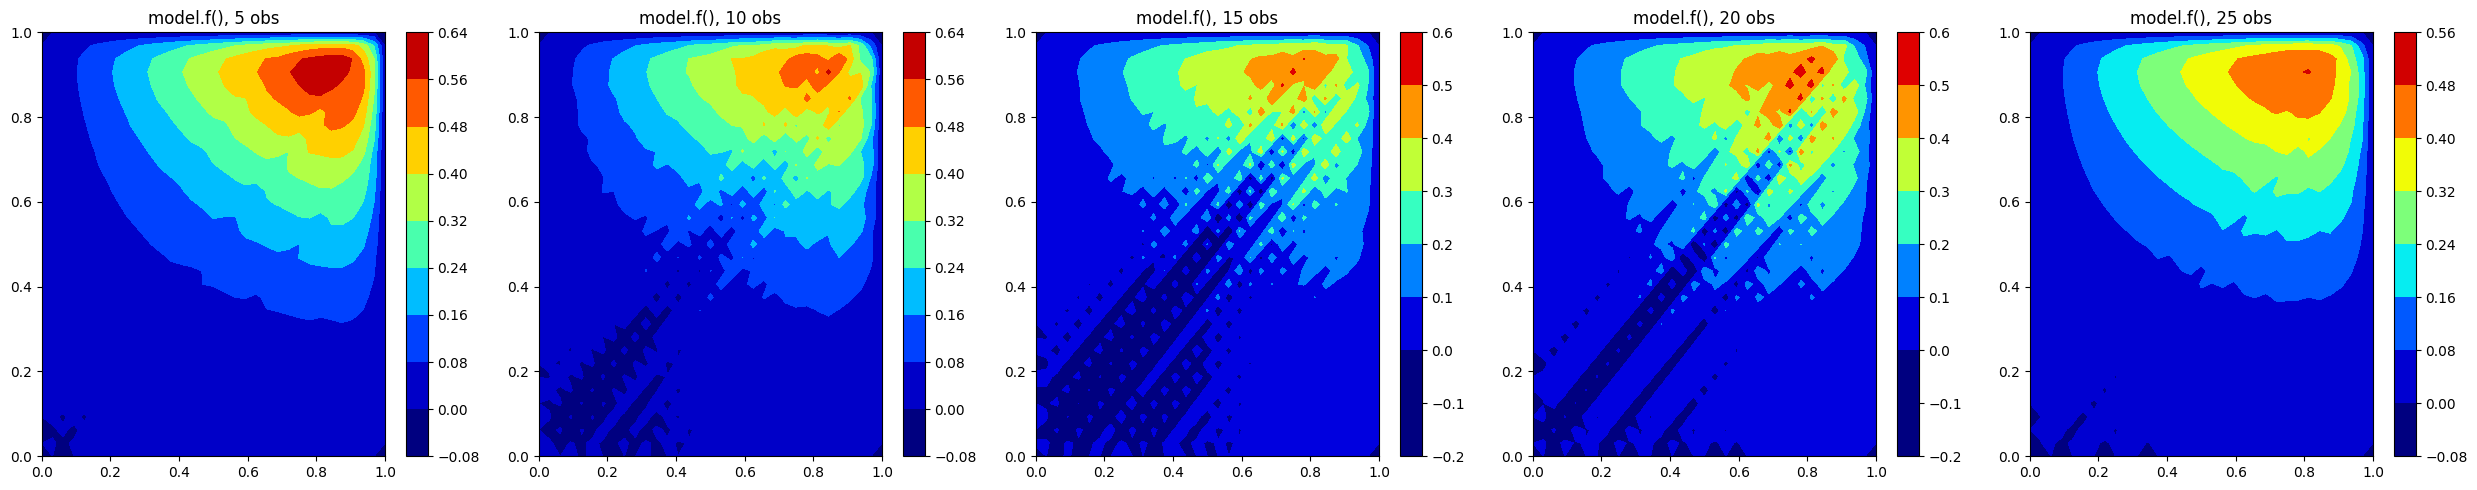

In [29]:
# model with Xi and stabilization parameter 6.03

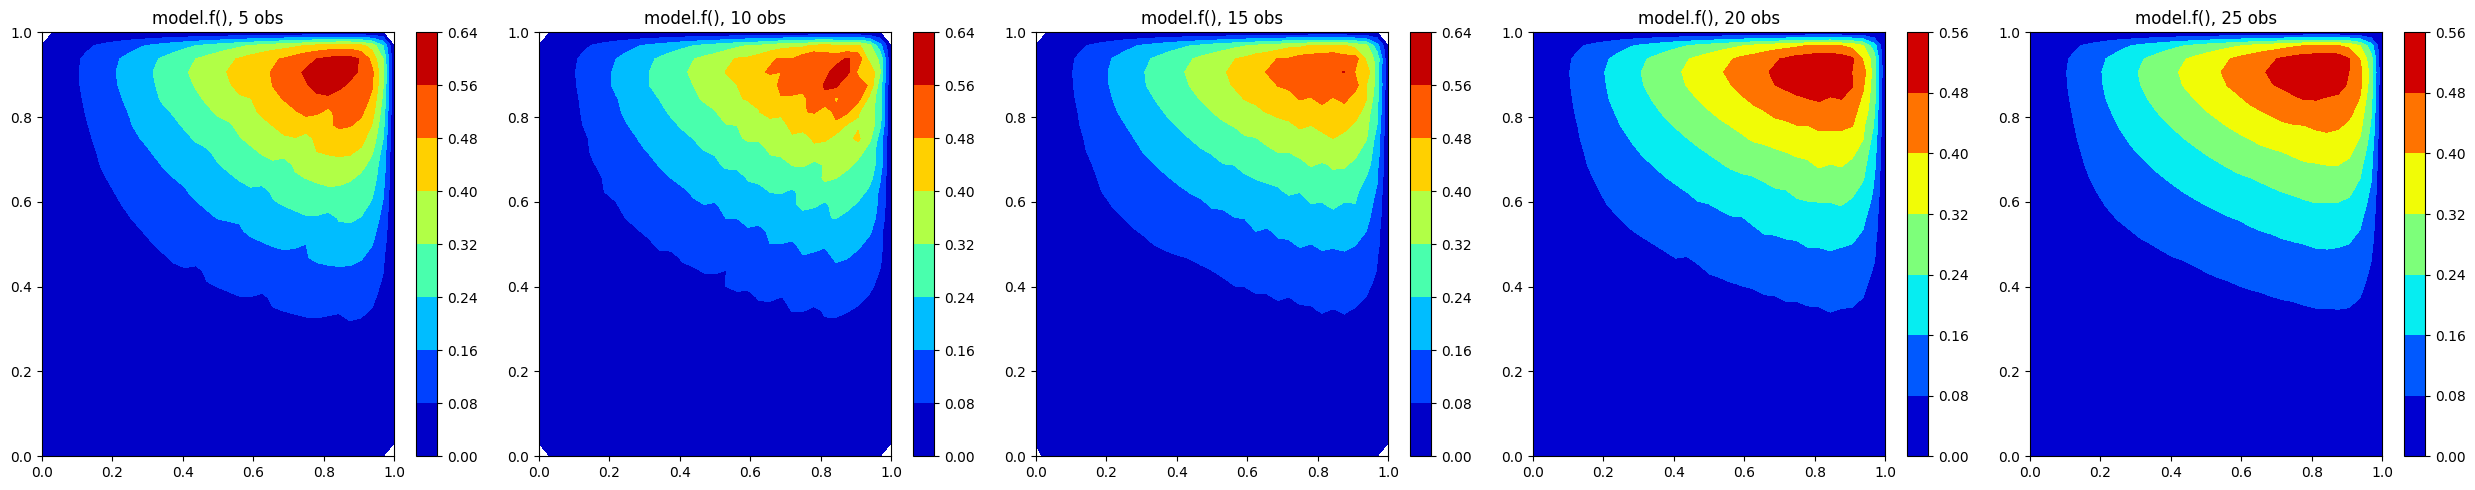

In [30]:
# stab param 46

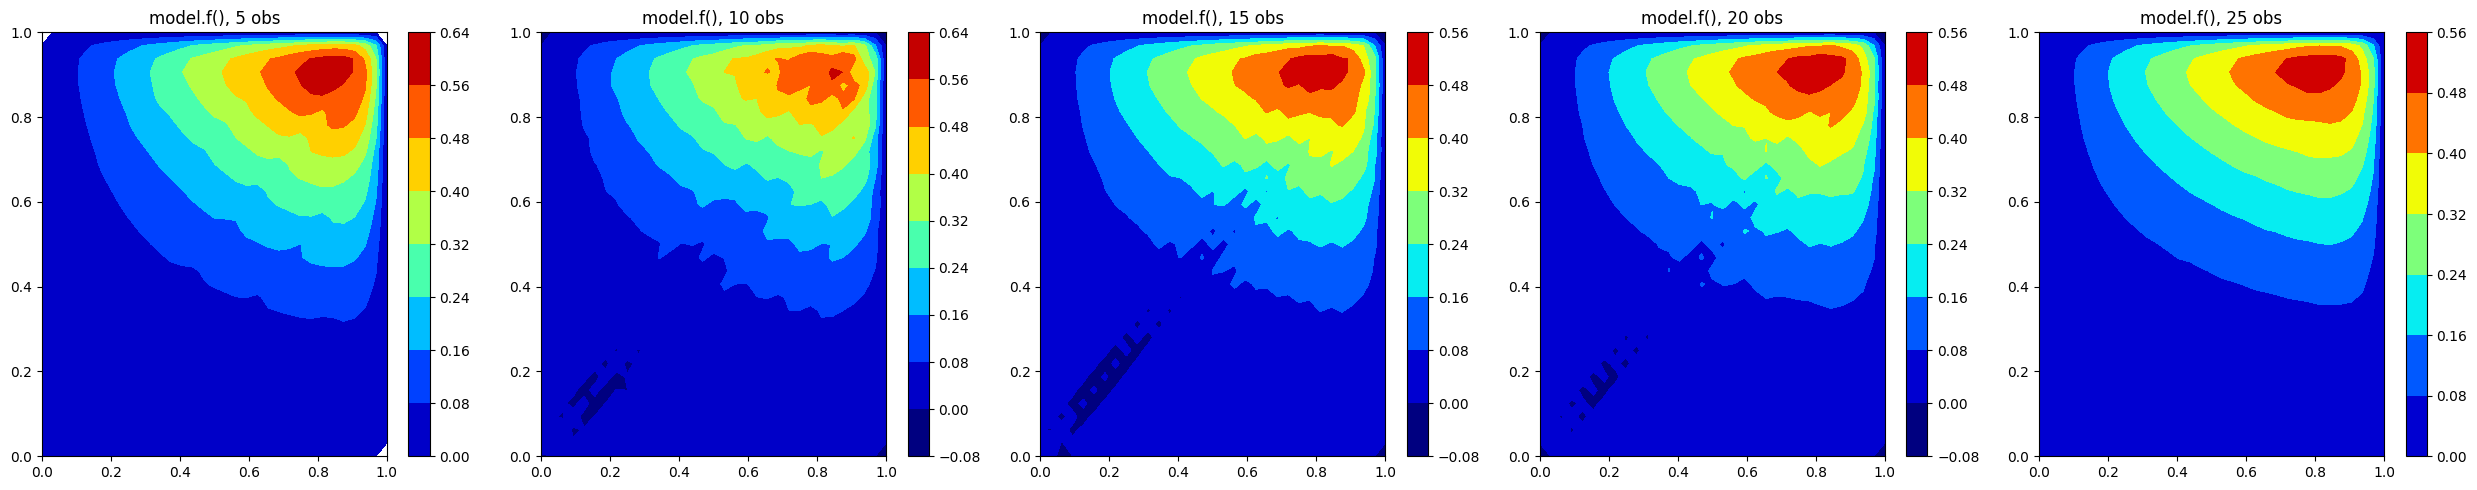

In [25]:
# ok, it followed the perturbed PDE. still some oscillations (without Xi)

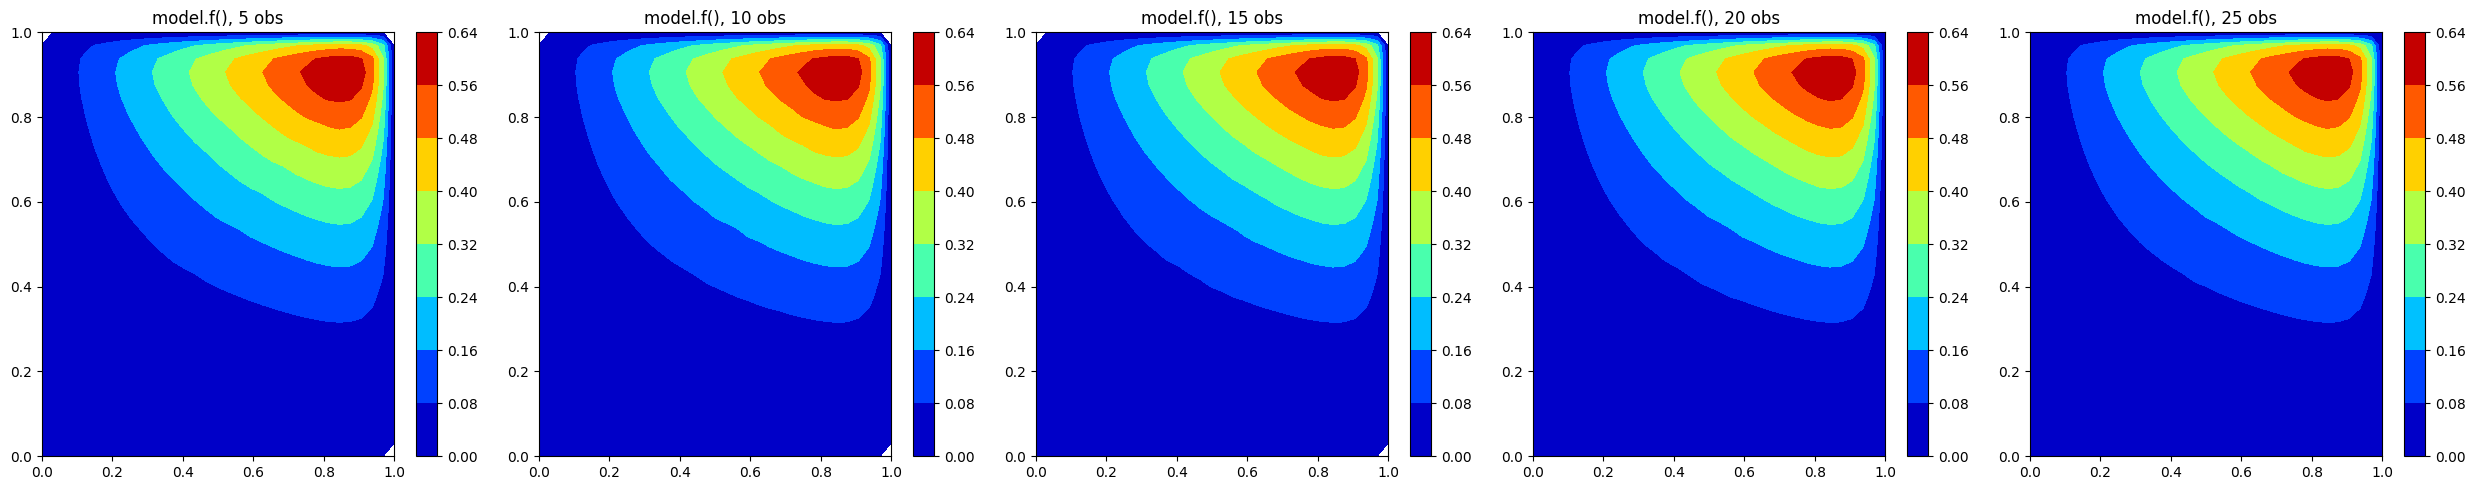

### Boxplots

In [ ]:
directory_testcase = './TestCase1/'
# build directory
directory_build = '../build/'
# remove directory and its content
try:
    shutil.rmtree(directory_testcase + 'RMSEs/')
except:
    pass
# recreate emtpy directory
os.makedirs(directory_testcase + 'RMSEs/')
# copy all .csv files from the directory .../build to the current directory
for file in os.listdir(directory_build):
    if file.endswith('.csv'):
        shutil.copy(directory_build + file, directory_testcase + 'RMSEs/') 

In [ ]:
data = {}
i = 5
while i <= 25:
    current = np.loadtxt(directory_testcase + 'RMSEs/RMSE_' + str(i) + '.csv')
    data[i] = current
    i += 5

plt.figure(figsize=(12, 6))
plt.boxplot(data.values())
plt.xticks(range(1, len(data.keys()) + 1), data.keys())
plt.savefig('./TestCase1/TestCase1_boxplots_pert_stab=1e5.png')
plt.show()

#### Prepare test locations different from mesh nodes when you have exact solution

In [ ]:
# test locations for the gridf
n = 100
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
z = np.array([[i, j] for i in x for j in y])
observations = exactSol(z[:,0], z[:,1])
row_indices = np.arange(1, n*n + 1)
result_matrix = np.column_stack((row_indices, observations))
column_names = np.array(['', 'x'])
result_matrix = np.vstack((column_names, result_matrix))
np.savetxt('../../fdaPDE-cpp/test/data/transport/TransportTestCase0/test_values.csv', result_matrix, delimiter=',', fmt='%s')

z = np.array([[j, i] for i in x for j in y])
z = np.column_stack((row_indices, z))
column_names = np.array(['', 'V1', 'V2'])
z = np.vstack((column_names, z))
np.savetxt('../../fdaPDE-cpp/test/data/transport/TransportTestCase0/test_locs.csv', z, delimiter=',', fmt='%s')


In [ ]:
# compare error between gridf and exact solution
gridf_exact = observations.reshape(100, 100).T # this transpose is the reason why I need to invert z to save the locations
plots2D(gridf_exact, 'gridf_exact')

In [ ]:
# put in a subplot 2x2 both gridf and observations transposed
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(gridf, cmap='jet', origin='lower')
plt.title('FEM interpolation of model.f()')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(gridf_exact, cmap='jet', origin='lower')
plt.title('exact sol')
plt.colorbar()
plt.tight_layout()
# save plot
plt.savefig('gridf_gridf_exact.png')
plt.show()


In [ ]:
# compute error between model.f() and the exact solution (data)
error = np.abs(gridf - gridf_exact)
# compute norm2 and norminf of the error
norm_error_2 = np.linalg.norm(error, 2)
norm_error_inf = np.linalg.norm(error, np.inf)
print("norm2 = ", norm_error_2)
print("norm_inf = ", norm_error_inf)

In [ ]:
plots2D(error, 'gridf_error')

### Interpolate result of perturbed PDE

In [ ]:
# import data form perturbed PDE
try:
    os.makedirs('TestCase1')
except:
    pass
fdaPDE_SUPG_sol  = '../../../fdaPDE-core/test/build/fdaPDE_SUPG_sol.txt'
shutil.copy(fdaPDE_SUPG_sol, './TestCase1/fdaPDE_SUPG_sol_perturbed.txt')

4225
N =  65


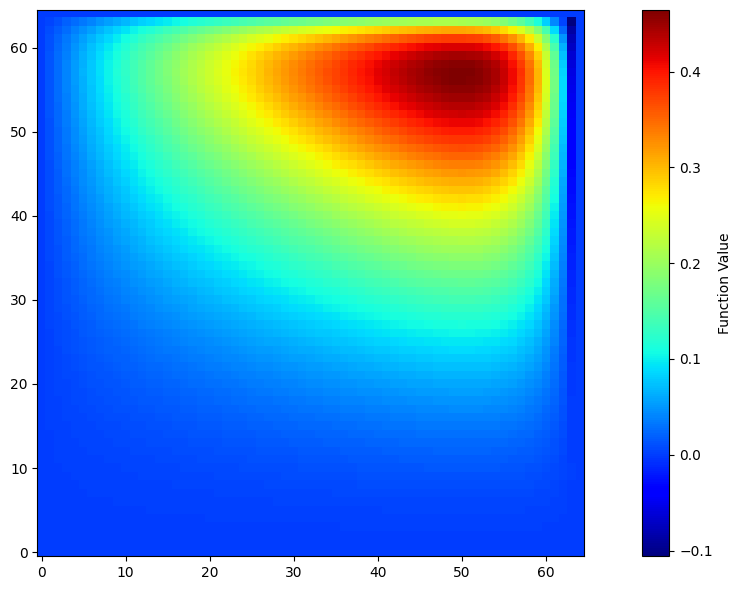

(65, 65)


In [51]:
path = 'TestCase1/fdaPDE_SUPG_sol_perturbed.txt'
# path = 'TestCase1/fdaPDE_SUPG_sol_no_stab.txt'
data = np.loadtxt(path, delimiter=',')
print(data.size)
N = int(np.sqrt(data.size))
print("N = ", N)
data = data.reshape(N,N)
plots2D(data, 'TestCase1_sol')
print(data.shape)

In [ ]:
plots2Dcontour(data, 'TestCase1_sol_contour_perturbed')

norm2 =  3.2179958222025644
norm_inf =  4.745106519262704


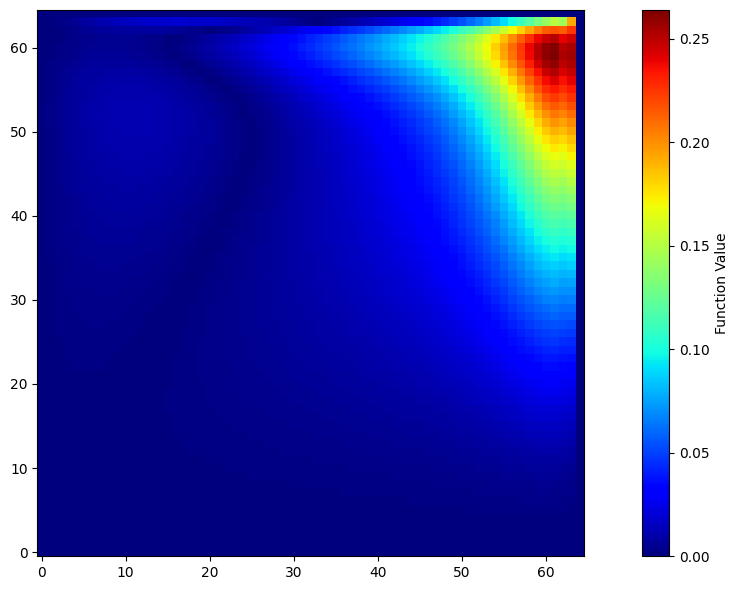

In [8]:
# compute errro with exact solution
error = np.abs(data - Z)
# compute norm2 and norminf of the error
norm_error_2 = np.linalg.norm(error, 2)
norm_error_inf = np.linalg.norm(error, np.inf)
print("norm2 = ", norm_error_2)
print("norm_inf = ", norm_error_inf)
plots2D(error, 'TestCase1_perturbed_error')

In [ ]:
plots2Dcontour(error, 'TestCase1_perturbed_error_contour')

In [20]:
from scipy.interpolate import RegularGridInterpolator
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
interpolating_function = RegularGridInterpolator((x, y), data, method='linear')

### Save locations and observations for FreeFEM format  (perturbed PDE)

In [21]:
n = 5
while n <= 25:
    t = np.linspace(0, 1, n)
    x, y = np.meshgrid(t, t)
    locs = np.array([x.flatten(), y.flatten()]).T     # careful with the ordering
    # locs = np.array([y.flatten(), x.flatten()]).T       # careful with the ordering

    np.savetxt('../data/transport/testPsi/locs' + str(n) + '.txt', locs.flatten(), delimiter=',', fmt='%.6f')

    observations = interpolating_function(locs)
    np.savetxt('../data/transport/testPsi/observations' + str(n) + '.txt', observations, delimiter=',', fmt='%.16f')
    n += 5

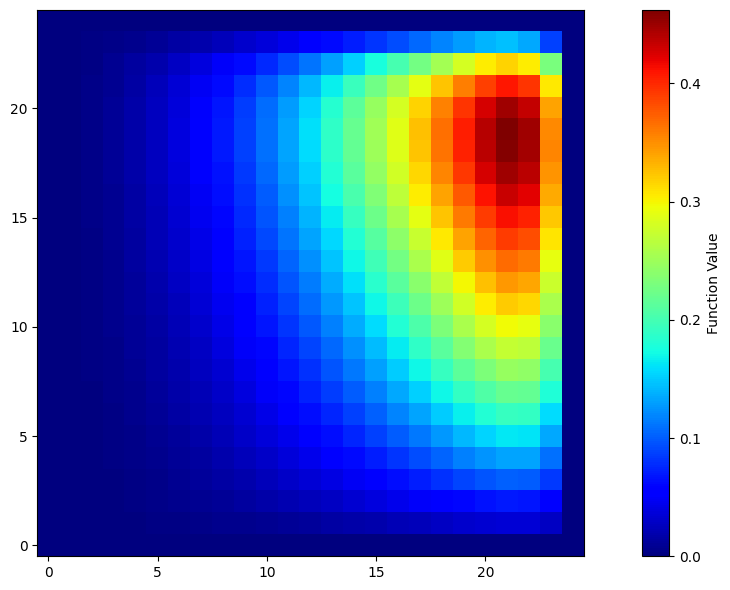

In [24]:
plots2D(observations.reshape(25,25))

In [ ]:
n = 6
while n <= 14:
    t = np.linspace(0, 1, n)
    x, y = np.meshgrid(t, t)
    # locs = np.array([x.flatten(), y.flatten()]).T # row major ordering
    locs = np.array([y.flatten(), x.flatten()]).T # column major ordering
    
    observations = interpolating_function(locs) #locs[:,0], locs[:,1])
    row_indices = np.arange(1, n*n + 1)
    result_matrix = np.column_stack((row_indices, observations))
    column_names = np.array(['', 'x'])
    result_matrix = np.vstack((column_names, result_matrix))
    np.savetxt('../data/transport/TransportTestCase1/observations' + str(n) + '.csv', result_matrix, delimiter=',', fmt='%s')
    
    locs = np.column_stack((row_indices, locs))
    column_names = np.array(['', 'V1', 'V2'])
    locs = np.vstack((column_names, locs))
    np.savetxt('../data/transport/TransportTestCase1/locs' + str(n) + '.csv', locs, delimiter=',', fmt='%s')
    n += 2

In [ ]:
plots2D(observations.reshape(14,14))

### Save $\texttt{expected()}$ for FreeFEM format (perturbed PDE)

In [22]:
expected = np.copy(data.flatten())
np.savetxt('../data/transport/testPsi/expected.txt', expected, delimiter=',', fmt='%.16f')

In [ ]:
expected = np.copy(data)
N = expected.size
row_indices = np.arange(1, N + 1)
expected = np.column_stack((row_indices, expected.flatten())) # row major ordering
column_names = np.array(['', 'x'])
expected = np.vstack((column_names, expected ))
np.savetxt('../data/transport/TransportTestCase1/expected.csv', expected, delimiter=',', fmt='%s')

In [ ]:

plt.figure(figsize=(12, 6))
plt.hist(data, bins=20, color='blue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of X')
plt.show()
